In [ ]:
# Importation des bibliothèques et des fonctions nécessaires
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import numpy as np



# Importations pour la construiction du modèle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.applications import EfficientNetB0

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
#!mkdir -p /content/drive/MyDrive/project/H5PY/dataset_batches/



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!find /content/drive/MyDrive -name "*.h5"


Mounted at /content/drive


- Chargement et apercu des métadonnées
<ul>
Cette étape consiste à charger les métadonnées de chaque classe d’images médicales depuis des fichiers Excel. Elle permet de connaître les labels et chemins des images pour préparer le dataset à l’entraînement du modèle. Un aperçu et le comptage des images sont effectués pour vérifier l’intégrité des fichiers.
</lu>

In [ ]:
# Lecture des fichiers Excel

base_dir = "/content/drive/MyDrive/project/COVID-19_Radiography_Dataset/"
# Lecture des fichiers metadata
df_normal = pd.read_excel(base_dir + "Normal.metadata.xlsx")
df_covid = pd.read_excel(base_dir + "COVID.metadata.xlsx")
df_opacity = pd.read_excel(base_dir + "Lung_Opacity.metadata.xlsx")
df_viral = pd.read_excel(base_dir + "Viral Pneumonia.metadata.xlsx")



- Vérification des données manquantes

<ul>

Ici, nous allons  analyser les métadonnées pour identifier les valeurs manquantes dans chaque classe d’images. Cela permet de détecter d’éventuelles données incomplètes et de planifier le nettoyage ou l’imputation avant l’entraînement du modèle.
</ul>

In [ ]:
# Dictionnaire pour les datasets

datasets = {
    'Normal': df_normal,
    'COVID': df_covid,
    'Lung_Opacity': df_opacity,
    'Viral_Pneumonia': df_viral
}

# Loop for extraire la largeur et l'hauteur de la colonne size
for name, df in datasets.items():
    df[['width', 'height']] = (
        df['SIZE']
        .str.lower()
        .str.split('*', expand=True)
        .astype(int)
    )

    # Affichage rapide pour vérification
    print(f" {name} — Dimensions extraites:")
    print(df[['width', 'height']].describe(), "\n")

 Normal — Dimensions extraites:
         width   height
count  10192.0  10192.0
mean     256.0    256.0
std        0.0      0.0
min      256.0    256.0
25%      256.0    256.0
50%      256.0    256.0
75%      256.0    256.0
max      256.0    256.0 

 COVID — Dimensions extraites:
        width  height
count  3616.0  3616.0
mean    256.0   256.0
std       0.0     0.0
min     256.0   256.0
25%     256.0   256.0
50%     256.0   256.0
75%     256.0   256.0
max     256.0   256.0 

 Lung_Opacity — Dimensions extraites:
        width  height
count  6012.0  6012.0
mean    256.0   256.0
std       0.0     0.0
min     256.0   256.0
25%     256.0   256.0
50%     256.0   256.0
75%     256.0   256.0
max     256.0   256.0 

 Viral_Pneumonia — Dimensions extraites:
        width  height
count  1345.0  1345.0
mean    256.0   256.0
std       0.0     0.0
min     256.0   256.0
25%     256.0   256.0
50%     256.0   256.0
75%     256.0   256.0
max     256.0   256.0 



**Croisement avec les fichiers pour vérifier la présence réelle des images**

<ul>

Cette étape consiste à vérifier la correspondance entre les fichiers listés dans les metadata et les images réellement présentes sur le disque pour chaque classe. Les fichiers manquants et non référencés sont identifiés afin d’assurer l’intégrité du dataset avant l’entraînement du modèle.
<ul>

In [ ]:
for name, df in datasets.items():
    # Nettoyage des noms de fichiers dans la colonne
    df['FILE NAME'] = df['FILE NAME'].str.strip()

    # Ajout de l'extension .png pour que ça corresponde aux fichiers réels
    df['file_name_fixed'] = df['FILE NAME'] + ".png"

    # Dossier contenant les vraies images
    image_dir = os.path.join(base_dir, name, "images")

    # Liste des fichiers présents sur disque
    try:
        actual_files = set(f.lower() for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')))
    except FileNotFoundError:
        print(f"Dossier introuvable : {image_dir}")
        continue

    # Liste des fichiers attendus selon le DataFrame
    expected_files = set(df['file_name_fixed'].str.lower())

    # Comparaison
    missing = expected_files - actual_files
    extra = actual_files - expected_files
    match = expected_files & actual_files

    # Résumé
    print(f" {name}")
    print(f"Images trouvées     : {len(match)}")
    print(f"Images manquantes   : {len(missing)}")
    print(f"Images non référencées : {len(extra)}\n")


 Normal
Images trouvées     : 10192
Images manquantes   : 0
Images non référencées : 0

 COVID
Images trouvées     : 3616
Images manquantes   : 0
Images non référencées : 0

 Lung_Opacity
Images trouvées     : 6012
Images manquantes   : 0
Images non référencées : 0

 Viral_Pneumonia
Images trouvées     : 1345
Images manquantes   : 0
Images non référencées : 0



**Filtration des DataFrames pour ne garder que les images existantes**

<ul>

Cette étape filtre le DataFrame pour ne conserver que les images présentes sur le disque, garantissant la cohérence entre les métadonnées et les fichiers réels. Elle permet de préparer le dataset pour l’entraînement du modèle sans provoquer d’erreurs lors du chargement des images.
</ul>

In [ ]:
for name, df in datasets.items():
    df['FILE NAME'] = df['FILE NAME'].str.strip()
    df['file_name_fixed'] = df['FILE NAME'] + ".png"
    image_dir = os.path.join(base_dir, name, "images")
    actual_files = set(f.lower() for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')))

    df_filtered = df[df['file_name_fixed'].str.lower().isin(actual_files)].copy()
    print(f"{name} : avant = {len(df)}, après filtre = {len(df_filtered)}")


    # Écrasement du DataFrame initial avec les données filtrées

    datasets[name] = df_filtered

Normal : avant = 10192, après filtre = 10192
COVID : avant = 3616, après filtre = 3616
Lung_Opacity : avant = 6012, après filtre = 6012
Viral_Pneumonia : avant = 1345, après filtre = 1345


- Création  d'un DataFrame global  pour fusionner toutes les classes

<ul>

Cette étape fusionne tous les datasets de différentes classes en un seul DataFrame global, réindexé pour garantir un index unique. Cela facilite les analyses statistiques, la visualisation et la préparation des données avant l’entraînement du modèle.
</ul>

In [ ]:
df_all = pd.concat(datasets.values(), ignore_index=True)
print(f"La fusion est  complète : {len(df_all)}")

La fusion est  complète : 21165


- Ajout d'une colonne 'label' à df_all contenant le nom de la classe
<ul>

Cette étape consiste à ajouter une colonne label à chaque dataset correspondant à la classe des images, puis à concaténer tous les datasets en un seul DataFrame global réindexé. Cela prépare le dataset pour les analyses et l’entraînement d’un modèle de classification supervisée.

</ul>

In [ ]:
# Liste pour stocker tous les DataFrames étiquetés
dfs = []

# Boucle sur le dictionnaire de datasets
for name, df in datasets.items():
    df = df.copy()
    df['label'] = name
    dfs.append(df)
    print(f"{name}: {len(df)} images")

# Concaténation de tous les DataFrames
df_all = pd.concat(dfs, ignore_index=True)

df_all.head()

Normal: 10192 images
COVID: 3616 images
Lung_Opacity: 6012 images
Viral_Pneumonia: 1345 images


,FILE NAME,FORMAT,SIZE,URL,width,height,file_name_fixed,label
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,256,256,NORMAL-1.png,Normal
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,256,256,NORMAL-2.png,Normal
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,256,256,NORMAL-3.png,Normal
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,256,256,NORMAL-4.png,Normal
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,256,256,NORMAL-5.png,Normal


**Preprocessing utilisant la fonction de keras image_dataset_from_directory**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# =====================================================================
# Chargement des jeux de données à partir des répertoires d’images
# =====================================================================

# La fonction `image_dataset_from_directory` permet de créer
# automatiquement des objets `tf.data.Dataset` à partir de la structure
# de dossiers. Chaque sous-dossier correspond à une classe.

# Structure attendue :
# /project/train/
#     ├── COVID/
#     ├── Lung_Opacity/
#     ├── Normal/
#     └── Viral_Pneumonia/
# /project/val/ (même structure)
# /project/test/ (même structure)

# Chaque image est :
#   - redimensionnée à 224×224 pixels (paramètre image_size)
#   - chargée par lot de 32 images (batch_size=32)
#   - associée automatiquement à un label entier selon son dossier parent
#   - convertie en tenseur TensorFlow (float32)

train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/project/train",
    batch_size=32,
    image_size=(224, 224),
)

val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/project/val",
    batch_size=32,
    image_size=(224, 224),
)

test_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/project/test",
    batch_size=32,
    image_size=(224, 224),
)

# À ce stade :
# - train_ds, val_ds et test_ds sont des objets `tf.data.Dataset`
# - Chaque élément est un tuple (images, labels)
# - Les labels sont générés automatiquement à partir des noms de dossiers


Found 13755 files belonging to 4 classes.
Found 3174 files belonging to 4 classes.
Found 4236 files belonging to 4 classes.


**Vérification**

In [ ]:
# Affichage des labels pour un seul batch
for images, labels in train_ds.take(1):  # Prendre un seul batch
    print("Labels pour ce batch :")
    print(labels.numpy())  # Afficher les labels sous forme de tableau numpy

Labels pour ce batch :
[2 3 2 2 0 2 2 1 2 1 1 2 2 1 2 0 2 0 1 1 1 1 2 2 2 1 2 2 3 0 2 1]


**Normalisation**

In [ ]:
# =====================================================================
# Normalisation des images dans les jeux de données
# =====================================================================

# Par défaut, les pixels des images chargées sont des entiers entre 0 et 255.
# Cette étape consiste à les normaliser dans l’intervalle [0, 1]
# afin de faciliter l’apprentissage du modèle (réduction des écarts de valeurs).

# La méthode `map()` applique une transformation à chaque élément du Dataset :
# ici, on divise chaque lot d’images (x) par 255.0, tout en conservant les labels (y).

# Après cette opération :
# - x devient un tenseur float32 avec des valeurs entre 0 et 1
# - y (les étiquettes) reste inchangé
# - Le pipeline reste compatible avec tf.data (entraînement efficace sur GPU)

train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds   = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds  = test_ds.map(lambda x, y: (x / 255.0, y))


**Chargement du modèle DenseNet121 de tensorflow.keras.applications**


<ul>

**But général :**

 Utiliser un modèle DenseNet121 pré-entraîné sur ImageNet comme extracteur de caractéristiques et ajouter des couches entièrement connectées pour la classification en 4 classes de notre dataset.


</ul>

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

#  Charger DenseNet121 sans la tête finale (include_top=False)
# input_shape = (224,224,3) pour correspondre à nos images
# weights='imagenet' pour utiliser les poids pré-entraînés

densenet121 = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

#  Geler le backbone DenseNet121
# On ne souhaite pas ré-entraîner les couches convolutionnelles du modèle pré-entraîné
# Cela permet d’utiliser les caractéristiques déjà apprises et réduit le temps d’entraînement

for layer in densenet121.layers:
    layer.trainable = False

# Construction de la tête du modèle personnalisé
x = densenet121.output
x = GlobalAveragePooling2D()(x)     # Transformation 2D → 1D en moyennant les cartes de caractéristiques
x = Dense(1024, activation='relu')(x)  # Couche dense avec 1024 neurones et activation ReLU
x = Dropout(0.2)(x)                 # Dropout pour réduire l’overfitting
x = Dense(512, activation='relu')(x)   # Deuxième couche dense de 512 neurones
x = Dropout(0.2)(x)                 # Dropout supplémentaire
output = Dense(4, activation='softmax')(x)  # Couche de sortie pour 4 classes avec softmax

# Définition du modèle complet
model = Model(inputs=densenet121.input, outputs=output)

# Affichage du résumé du modèle ---
# Utile pour vérifier le nombre de paramètres, la forme des couches et le blocage du backbone
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,613,956 (32.86 MB)

 Trainable params: 1,576,452 (6.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

- **Compilation du modele**

**But général :**

Débloquer certaines couches du modèle pré-entraîné pour permettre un ajustement plus fin (fine-tuning) sur notre dataset spécifique tout en conservant la majorité des poids pré-entraînés pour éviter l'overfitting.

In [ ]:
# Débloquer les 50 dernières couches du backbone
# Les couches initiales capturent des caractéristiques générales (bords, textures),
# tandis que les couches finales capturent des caractéristiques spécifiques à la tâche.
# On ne veut ré-entraîner que les couches finales pour adapter le modèle à notre dataset.

for layer in densenet121.layers[-50:]:
    layer.trainable = True


#  Compilation du modèle
# Optimiseur : Adam avec un learning rate très faible (1e-5) pour ne pas détruire
# les poids pré-entraînés déjà utiles.
# Loss : sparse_categorical_crossentropy car les labels sont sous forme d'entiers.
# Metrics : 'accuracy' pour suivre la performance du modèle lors de l'entraînement.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Définition des callbacks**

In [ ]:
# =====================================================================
# Définition des callbacks pour un entraînement plus efficace
# =====================================================================

# --- EarlyStopping ---
# Surveille la performance du modèle sur les données de validation (val_loss).
# Si la loss de validation n’a pas diminué après 5 epochs consécutives,
# l’entraînement s’arrête automatiquement pour éviter le surapprentissage (overfitting).
# L’option `restore_best_weights=True` permet de restaurer les poids du modèle
# correspondant à la meilleure performance atteinte pendant l’entraînement.

early_stopping = EarlyStopping(
    monitor='val_loss',        # métrique surveillée
    patience=5,                # nombre d’epochs sans amélioration avant arrêt
    restore_best_weights=True  # restaure les meilleurs poids
)


# --- ReduceLROnPlateau ---
# Ce callback ajuste dynamiquement le taux d’apprentissage (learning rate)
# lorsque la performance du modèle stagne.
# Si la loss de validation n’améliore pas après 3 epochs,
# le learning rate est réduit d’un facteur 0.1 (divisé par 10).
# Cela aide le modèle à continuer à apprendre plus finement.
# - monitor='val_loss' : surveille la métrique de validation
# - factor=0.1 : multiplicateur du learning rate
# - patience=3 : nombre d’epochs sans amélioration avant réduction
# - min_lr=1e-6 : limite inférieure du learning rate
# - verbose=1 : affiche un message à chaque ajustement

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


**Entrainement du modèle**

-  **But général :**

 Entraîner le modèle sur notre dataset en utilisant le fine-tuning partiel déjà défini, tout en gérant l'optimisation, le suivi et les déséquilibres de classes.


In [ ]:
# =====================================================================
# Importation des bibliothèques nécessaires
# =====================================================================
# - numpy : pour la manipulation de tableaux
# - tensorflow : pour la construction et l’entraînement du modèle
# - LabelEncoder : pour transformer les étiquettes en entiers
# - CSVLogger : pour enregistrer les résultats de chaque epoch
# - compute_class_weight : pour corriger le déséquilibre des classes
# - EarlyStopping, ReduceLROnPlateau, ModelCheckpoint : callbacks utiles à l’entraînement

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import CSVLogger
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# =====================================================================
# Sauvegarde automatique du meilleur modèle pendant l’entraînement
# =====================================================================
# ModelCheckpoint :
# - monitor='val_loss' → surveille la perte sur les données de validation
# - save_best_only=True → sauvegarde uniquement le modèle ayant la meilleure val_loss
# - save_weights_only=False → enregistre l’architecture + les poids
# - mode='min' → cherche à minimiser la métrique suivie

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/project/H5PY/densenet121_checkpoint.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


# =====================================================================
# Optimisation du pipeline de données TensorFlow
# =====================================================================
# - cache() : garde les données en mémoire après leur premier chargement,
#             accélérant les epochs suivantes.
# - shuffle(1000) : mélange aléatoirement les échantillons pour éviter un biais d’ordre.
# - prefetch(AUTOTUNE) : prépare à l’avance les lots suivants pour un entraînement fluide.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# =====================================================================
# Calcul des poids de classes pour corriger le déséquilibre
# =====================================================================
# Certaines classes peuvent être sous-représentées.
# compute_class_weight attribue un poids inversement proportionnel
# à la fréquence de chaque classe, améliorant ainsi l’équilibre de l’apprentissage.

labels = df_all['label'].values       # Récupère les étiquettes originales
le = LabelEncoder()
y_encoded = le.fit_transform(labels)  # Encode les labels sous forme d'entiers

classes_presentes = np.unique(y_encoded)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes_presentes,
    y=y_encoded
)

# Dictionnaire {classe: poids}
class_weight_dict = {cls: weight for cls, weight in zip(classes_presentes, class_weights)}

# Affichage pour vérification
print("Poids des classes :")
for cls_idx, weight in class_weight_dict.items():
    print(f"Classe '{le.inverse_transform([cls_idx])[0]}' ({cls_idx}) -> poids {weight:.3f}")


# =====================================================================
# Entraînement du modèle
# =====================================================================
# - csv_logger : enregistre les métriques d’entraînement dans un fichier CSV
# - class_weight : applique les poids de classes calculés
# - callbacks : liste des fonctions de contrôle (EarlyStopping, ReduceLROnPlateau, Checkpoint)
# L'entraînement s'arrêtera automatiquement si la performance stagne (early stopping)
# et sauvegardera le meilleur modèle (checkpoint).

csv_logger = CSVLogger("training_log.csv", append=True)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_learning_rate, checkpoint]
)


# =====================================================================
# Sauvegarde finale du modèle complet entraîné
# =====================================================================
# Le modèle final (architecture + poids) est enregistré au format .keras
# pour pouvoir être rechargé ultérieurement sans avoir à le réentraîner.

model.save('/content/drive/MyDrive/project/H5PY/cnn_densenet121_modele_masks.keras')


Poids des classes :
Classe 'COVID' (0) -> poids 1.463
Classe 'Lung_Opacity' (1) -> poids 0.880
Classe 'Normal' (2) -> poids 0.519
Classe 'Viral_Pneumonia' (3) -> poids 3.934
Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3428s 5s/step - accuracy: 0.5631 - loss: 1.0065 - val_accuracy: 0.7240 - val_loss: 0.6563 - learning_rate: 5.0000e-05
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2062s 5s/step - accuracy: 0.7278 - loss: 0.5978 - val_accuracy: 0.7561 - val_loss: 0.6067 - learning_rate: 5.0000e-05
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1956s 5s/step - accuracy: 0.7459 - loss: 0.5512 - val_accuracy: 0.7990 - val_loss: 0.5117 - learning_rate: 5.0000e-05
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1946s 4s/step - accuracy: 0.7746 - loss: 0.4995 - val_accuracy: 0.7921 - val_loss: 0.5164 - learning_rate: 5.0000e-05
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2023s 5s/step - accuracy: 0.7790 - loss: 0.4813 - val_accuracy: 0.8021 - val_loss: 0.5014 - learning_rate: 5.0000e-05
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━

- **Afficher les courbes d'entraînement**

**But général :**

Suivre graphiquement la performance du modèle au cours des epochs pour détecter le sur-apprentissage, le sous-apprentissage ou tout problème d'entraînement.

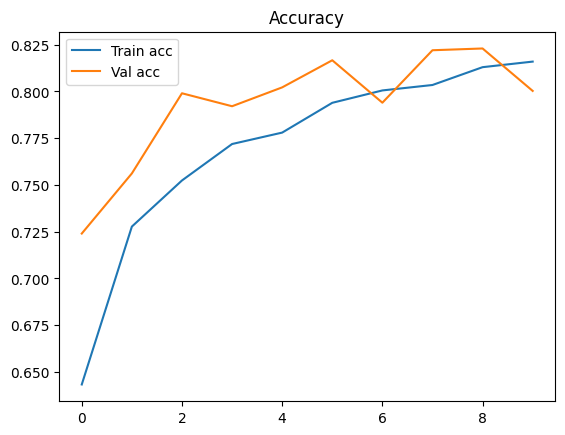

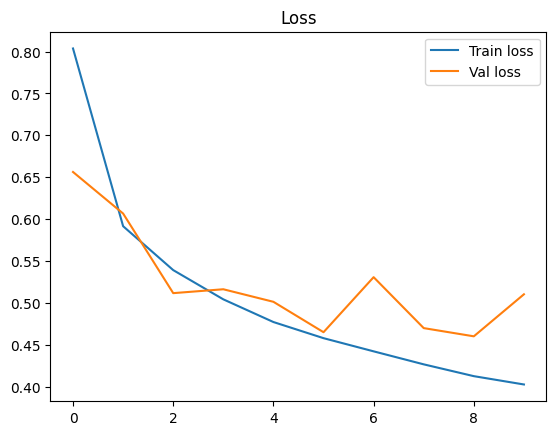

In [ ]:
# =====================================================================
# Visualisation des courbes d'entraînement : Accuracy et Loss
# =====================================================================

# L’objet 'history' contient les métriques enregistrées pendant l'entraînement
# (renvoyé par model.fit()). On les récupère sous forme de dictionnaire.
history_dict = history.history

# ---------------------------------------------------------------------
# Courbe de précision (Accuracy)
# ---------------------------------------------------------------------
# On trace ici l'évolution de la précision (accuracy) sur :
# - les données d'entraînement ('accuracy')
# - les données de validation ('val_accuracy')
# Ces courbes permettent de vérifier si le modèle apprend correctement
# sans surapprentissage (overfitting).
plt.plot(history_dict['accuracy'], label='Train acc')
plt.plot(history_dict['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# ---------------------------------------------------------------------
# Courbe de perte (Loss)
# ---------------------------------------------------------------------
# De même, on trace la perte (loss) sur :
# - l'ensemble d'entraînement ('loss')
# - l'ensemble de validation ('val_loss')
# Une divergence entre les deux courbes (perte de validation qui augmente)
# peut indiquer un surapprentissage.
plt.plot(history_dict['loss'], label='Train loss')
plt.plot(history_dict['val_loss'], label='Val loss')
plt.legend()
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


**Interprétation**

1. Progression de la précision

La précision sur les données d'entraînement (Train acc) augmente régulièrement au fur et à mesure que les époques progressent, atteignant un plateau vers la fin. Cela suggère que le modèle continue à s'améliorer sur l'ensemble d'entraînement au fil des époques.

La précision sur les données de validation (Val acc) augmente également, mais elle semble se stabiliser plus tôt et parfois osciller légèrement après une certaine époque. Cela pourrait indiquer que le modèle s'ajuste bien aux données de validation, mais peut-être qu'il commence à surajuster (overfitting) les données d'entraînement au bout de quelques époques.

2. Comparaison entre l'entraînement et la validation

La différence entre la précision d'entraînement et la précision de validation suggère qu'il pourrait y avoir un petit surapprentissage (overfitting), notamment si la précision d'entraînement continue de grimper alors que la précision de validation se stabilise ou commence à stagner.

Overfitting se produit lorsque le modèle devient trop spécialisé pour les données d'entraînement et ne généralise plus bien aux nouvelles données (données de validation dans ce cas). Cela pourrait être amélioré en régularisant davantage le modèle ou en utilisant plus de données de validation.

3. les valeurs de perte

- Évolution de la perte d'entraînement

La perte d'entraînement (Train loss) diminue constamment au fur et à mesure des époques, ce qui indique que le modèle s'améliore sur les données d'entraînement. Cela montre que le modèle apprend à mieux s'ajuster aux données d'entraînement, ce qui est attendu pendant l'apprentissage.

- Évolution de la perte de validation

La perte de validation (Val loss) diminue également, mais elle semble fluctuer ou stagner davantage après quelques époques. Cela pourrait indiquer que le modèle atteint un point où il est capable de mieux généraliser aux données de validation, mais qu'il n'est pas nécessairement en train de s'améliorer de manière significative sur ces données à chaque époque.

- Comparaison entre la perte d'entraînement et la perte de validation

Au début de l'entraînement, la perte de validation est relativement plus élevée que la perte d'entraînement, ce qui est normal car le modèle commence à s'ajuster à l'ensemble de validation.

Cependant, après quelques époques, on remarque que la perte d'entraînement continue de diminuer de manière régulière, tandis que la perte de validation semble se stabiliser ou fluctuer. Cela pourrait suggérer un surajustement (overfitting), où le modèle s'améliore davantage sur les données d'entraînement, mais ne parvient pas à mieux généraliser sur les données de validation.

**Chargement du modèle pour faire les prédictions**

In [ ]:
# Charger le modèle sauvegardé
model = load_model('/content/drive/MyDrive/project/H5PY/cnn_densenet121_modele_masks.keras')

**Prédictions**

In [ ]:
# =====================================================================
# Évaluation du modèle sur les données de test
# =====================================================================

from sklearn.metrics import classification_report, confusion_matrix

# ---------------------------------------------------------------------
# Fonction pour extraire :
# - les vraies étiquettes (true_labels)
# - les prédictions du modèle (pred_labels)
# - les probabilités associées à chaque classe (pred_probs)
# ---------------------------------------------------------------------
def get_predictions_labels_probs(dataset, model):
    true_labels = []
    pred_labels = []
    pred_probs = []

    # Parcourt le jeu de test par batch
    for images, labels in dataset:
        # Prédit les probabilités pour chaque classe
        preds = model.predict(images, verbose=0)

        # Stocke les probabilités (utile pour ROC, AUC, etc.)
        pred_probs.extend(preds)

        # Convertit les probabilités en labels (classe avec la plus forte proba)
        pred_labels.extend(np.argmax(preds, axis=-1))

        # Stocke les vraies étiquettes
        true_labels.extend(labels.numpy())

    # Retourne les trois tableaux sous forme numpy
    return np.array(true_labels), np.array(pred_labels), np.array(pred_probs)


# ---------------------------------------------------------------------
# Application de la fonction au jeu de test
# ---------------------------------------------------------------------
y_true, y_pred, y_prob = get_predictions_labels_probs(test_ds, model)

# ---------------------------------------------------------------------
# Rapport de classification
# ---------------------------------------------------------------------
# Affiche la précision, le rappel et le F1-score pour chaque classe,
# ainsi que les moyennes globales (macro / weighted).
# Permet d’évaluer le comportement du modèle par classe.
print(classification_report(y_true, y_pred))

# ---------------------------------------------------------------------
# Matrice de confusion
# ---------------------------------------------------------------------
# Montre le nombre de prédictions correctes et incorrectes pour chaque classe.
# Les diagonales représentent les bonnes prédictions.
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.72      0.68       724
           1       0.84      0.79      0.81      1203
           2       0.88      0.86      0.87      2039
           3       0.78      0.96      0.86       270

    accuracy                           0.82      4236
   macro avg       0.79      0.83      0.81      4236
weighted avg       0.82      0.82      0.82      4236

[[ 518   89  111    6]
 [ 129  946  117   11]
 [ 144   91 1746   58]
 [   0    3    8  259]]




<hr style="border: 1px solid #0080ff;">

$$\text{Rapport de classification}$$

<hr style="border: 1px solid #0080ff;">

Le modèle montre des performances globales excellentes :

<ul>

**Précision :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

La précision pour chaque classe est supérieure à 65%, ce qui suggère que le modèle commet relativement peu d'erreurs lorsqu'il prédit une classe positive.

</div>
</ul>


**Rappel :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

Le modèle a un excellent rappel pour Classe 3 (Viral_Pneumonia) avec un rappel de 0.96, ce qui signifie qu'il identifie la plupart des instances de cette classe.


Le rappel est également bon pour les autres classes.

</div>
</ul>




**F1-Score :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

Le F1-score est très bon pour toutes les classes (autour de 0.82), ce qui montre un bon compromis entre précision et rappel.

</div>
</ul>


**Accuracy :**

<ul>
<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

L'accuracy globale est de 82%, ce qui est un très bon résultat pour un modèle de classification d'images. Cela signifie que le modèle fait une prédiction correcte pour environ 82% des images.

</div>
</ul>



**Classement des classes :**

<ul>

<div style="border-left: 5px solid #00ffbf; padding: 10px; background: white;">

Classe 0 (COVID) : Le modèle a une précision de 65% et un rappel de 72%.



Classe 1 (Lung_Opacity) : La précision est de 84%, et le rappel est de 79%.


Classe 2 (Normal) : Précision de 88%, rappel de 86%.


Classe 3 (Viral_Pneumonia) : Précision de 78%, rappel de 96%.

</div>
</ul>
</ul>

<hr style="border: 1px solid #0080ff;">

$$\text{Matrice de confusion}$$
<hr style="border: 1px solid #0080ff;">
<ul>

La matrice de confusion montre les performances du modèle de manière plus détaillée, et les résultats sont très bons :

| Réel \\ Prédit | COVID | Lung_Opacity | Normal | Viral_Pneumonia |
|----------------|:------:|:-------------:|:-------:|:----------------:|
| **COVID** | **518** | 89 | 111 | 6 |
| **Lung_Opacity** | 129 | **946** | 117 | 11 |
| **Normal** | 144 | 91 | **1746** | 58 |
| **Viral_Pneumonia** | 0 | 3 | 8 | **259** |

</ul>

<hr style="border: 1px solid #0080ff;">

$$\text{Interprétation}$$

<hr style="border: 1px solid #0080ff;">
<ul>

**. Classe 0 (COVID) :**

<ul>

518 images de COVID ont été correctement classées comme COVID.


Le modèle présente quelques erreurs de classification, avec 89 images mal classées en Lung_Opacity, 111 en Normal, et 6 en Viral_Pneumonia. Toutefois, ces erreurs restent relativement faibles par rapport au nombre total d'images. Cela suggère que le modèle fonctionne globalement bien, même s'il pourrait encore être amélioré pour réduire davantage ces erreurs, notamment pour les classes Lung_Opacity et Normal, où les erreurs sont plus fréquentes.

</ul>


**. Classe 1 (Lung_Opacity) :**

<ul>

La majorité des images de Lung_Opacity sont correctement classées (946).


117 images de cette classe sont mal classées en Normal, ce qui est l'une des erreurs principales.

</ul>



**. Classe 2 (Normal) :**

<ul>

1746 images sont correctement classées comme Normal.


Il y a un nombre raisonnable d'images mal classées dans COVID-19 (144), mais la majorité des prédictions sont correctes.

</ul>



**. Classe 3 (Viral_Pneumonia) :**

<ul>

Très peu d'erreurs pour Viral_Pneumonia, avec seulement 3 images mal classées en Lung_Opacity et 8 en Normal.


Cela montre que le modèle fait un excellent travail pour identifier les cas de Viral_Pneumonia.
</ul>


</ul>

<hr style="border: 1px solid #0080ff;">

$$\text{Conclusion}$$

<hr style="border: 1px solid #0080ff;">
<ul>

Le modèle a maintenant des bonnes  performances. Les résultats de la précision, du rappel et du F1-score montrent que le modèle prédit correctement la plupart des classes, en particulier la classe Viral_Pneumonia avec un rappel de 96%.


Les erreurs de classification restantes sont principalement dues à des confusions entre des classes similaires (par exemple, Lung_Opacity et Normal), ce qui est normal dans les tâches de classification d'images complexes.


</ul>
</ul>



**Evaluation du modèle**

In [ ]:
# =====================================================================
# Évaluation finale du modèle sur le jeu de test
# =====================================================================

# La méthode `evaluate()` calcule les métriques définies lors de la compilation du modèle
# (par exemple : loss, accuracy, etc.) sur un dataset donné.
# Ici, on évalue le modèle sur le jeu de test, qui n’a jamais été vu pendant l’entraînement
# ni pendant la validation.
# Cela permet de mesurer la capacité de généralisation du modèle.

test_loss, test_acc = model.evaluate(test_ds)

# Affichage de la précision finale sur le jeu de test
print(f"Test accuracy: {test_acc:.4f}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 599s 5s/step - accuracy: 0.8091 - loss: 0.4757
Test accuracy: 0.8189


- **confusion avec normalisation**

**But général :**

Vérifier quantitativement les performances du modèle sur le dataset de test.
La matrice de confusion montre combien d'échantillons de chaque classe ont été correctement ou incorrectement classés.


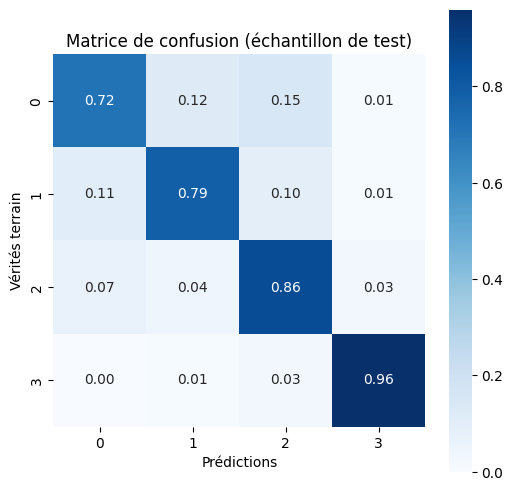

In [ ]:
# =====================================================================
# Visualisation de la matrice de confusion normalisée
# =====================================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------------------------------------------------------------------
# Calcul de la matrice de confusion
# ---------------------------------------------------------------------
# La matrice de confusion compare les prédictions du modèle (y_pred)
# aux vraies étiquettes (y_true).
# L’option normalize='true' permet de normaliser les valeurs par ligne,
# c’est-à-dire que chaque ligne (classe réelle) somme à 1.
# Cela permet de visualiser les proportions plutôt que les valeurs absolues.
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# ---------------------------------------------------------------------
# Affichage de la matrice de confusion
# ---------------------------------------------------------------------
# On utilise seaborn.heatmap pour représenter la matrice sous forme colorée.
# - annot=True : affiche les valeurs dans les cases
# - fmt=".2f" : deux décimales
# - cmap="Blues" : palette de couleur bleue
# - square=True : cases carrées pour une présentation plus claire
plt.figure(figsize=(6, 6))
sns.heatmap(cnf_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)

# Étiquettes et titre
plt.xlabel("Prédictions du modèle")
plt.ylabel("Étiquettes réelles")
plt.title("Matrice de confusion normalisée (jeu de test)")

plt.show()


**Interprétation**

<ul>

**.** Le modèle est globalement très performant, avec des taux de bonne classification supérieurs à 0.82% pour toutes les classes.

**.** Les classes  Viral_Pneumonia est particulièrement bien reconnue (96 % ).

**.** Les classes COVID,  Lung_Opacity et Normal présentent un peu plus de confusion entre elles, ce qui peut être cohérent sur le plan médical (leurs radiographies peuvent être visuellement similaires).

</ul>



* **Visualisation: Inspection de quelques prédictions**

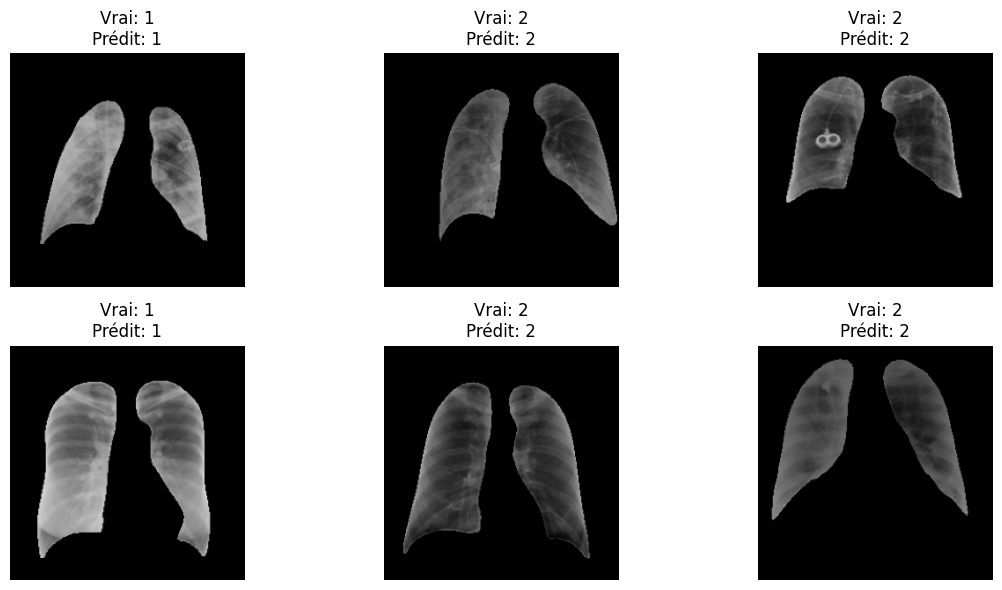

In [ ]:
# Nombre d'images à afficher
num_images = 6

# Récupérer toutes les images du dataset test_ds (batché)
all_images = []
for batch_images, _ in test_ds:
    all_images.append(batch_images.numpy())
all_images = np.concatenate(all_images, axis=0)

# Tirer 6 indices aléatoires
indices = np.random.choice(len(y_true), num_images, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    plt.subplot(2, 3, i + 1)  # 2 lignes, 3 colonnes
    plt.imshow(all_images[idx])
    plt.title(f"Vrai: {y_true[idx]}\nPrédit: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


- **Courbe des valeurs réelles vs prédites**

**But général :**

 Comparer visuellement les prédictions du modèle (y_pred) avec les vraies étiquettes (y_test) sur un sous-échantillon pour identifier facilement les erreurs.

In [ ]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

# Convertir y_true one-hot en indices
y_true_indices = y_true
y_pred_indices = y_pred  # déjà des entiers

n_values = min(100, len(y_true_indices))
indices = np.arange(n_values)
y_true_subset = y_true_indices[:n_values]
y_pred_subset = y_pred_indices[:n_values]

correct_mask = y_true_subset == y_pred_subset
incorrect_mask = y_true_subset != y_pred_subset

correct_indices = indices[correct_mask]
incorrect_indices = indices[incorrect_mask]

y_correct = y_true_subset[correct_mask]
y_incorrect = y_true_subset[incorrect_mask]

fig = go.Figure()

# Points correctement classés
fig.add_trace(go.Scatter(
    x=correct_indices,
    y=y_correct,
    mode='markers',
    name='Correctement classé',
    marker=dict(size=8, color='#00ff00', symbol='circle'),
    text=[f"Réel: {class_names[y]}, Prédit: {class_names[y_pred_subset[i]]}"
          for i, y in enumerate(y_correct)],
    hovertemplate='Index: %{x}<br>%{text}<extra></extra>'
))

# Points mal classés
fig.add_trace(go.Scatter(
    x=incorrect_indices,
    y=y_incorrect,
    mode='markers',
    name='Mal classé',
    marker=dict(size=8, color='#e60000', symbol='x'),
    text=[f"Réel: {class_names[y_true_subset[i]]}, Prédit: {class_names[y_pred_subset[i]]}"
          for i in np.where(incorrect_mask)[0]],
    hovertemplate='Index: %{x}<br>%{text}<extra></extra>'
))

# Ligne grise des valeurs réelles
fig.add_trace(go.Scatter(
    x=indices,
    y=y_true_subset,
    mode='lines',
    name='Valeurs réelles',
    line=dict(color='gray', width=1),
    showlegend=False
))

fig.update_yaxes(
    tickvals=[0, 1, 2, 3],
    ticktext=class_names,
    title_text="Classe réelle"
)

fig.update_layout(
    title=f"Valeurs correctement et incorrectement classées sur {n_values} échantillons",
    xaxis_title="Index des échantillons",
    width=1000,
    height=600,
    showlegend=True
)

fig.show()


- **Courbes ROC et AUC pour la classe COVID-19**

**But général :**

Évaluer la capacité du modèle à distinguer les images positives (COVID) des négatives pour cette classe.

La courbe ROC (Receiver Operating Characteristic) montre le compromis entre le taux de vrais positifs (TPR) et le taux de faux positifs (FPR).


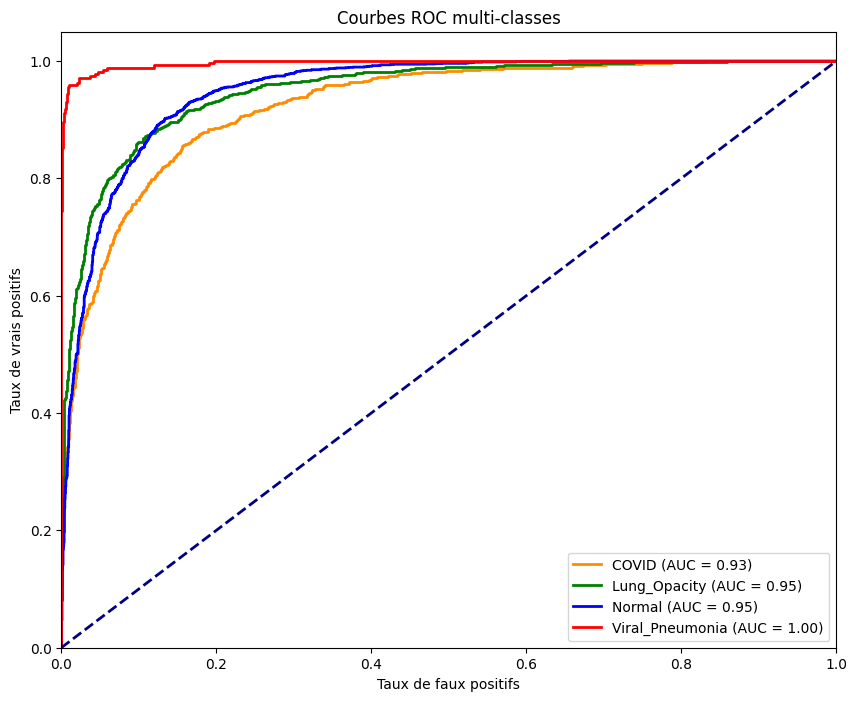

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binariser les vraies étiquettes
y_true_bin = label_binarize(y_true, classes=[0,1,2,3])

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
colors = ['darkorange', 'green', 'blue', 'red']

plt.figure(figsize=(10, 8))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC multi-classes')
plt.legend(loc="lower right")
plt.show()


Ce que cette figure montre :

La courbe ROC montre le compromis entre les faux positifs et les vrais positifs.

L'AUC (Area Under the Curve) donne une mesure globale de la performance du modèle. Une AUC de 1 indique un modèle parfait, tandis qu'une AUC de 0.5 suggère une performance aléatoire.

**Interprétation**

Dàprès cette courbe ROC, nous constatons que :
<ul>

**.** le modèle détecte presque correctement les cas COVID-19.

**.** le modèle fait très peu d'erreurs(peu de faux positifs et faux négatifs)

**.** le modèle est  fiable pour la classe COVID-19 selon les données testées.

</ul>

- **Distribution des erreurs de prédiction**

**But général :**

 Identifier quelles classes sont les plus sujettes aux erreurs de prédiction.

 Cette étape permet de diagnostiquer les points faibles du modèle.

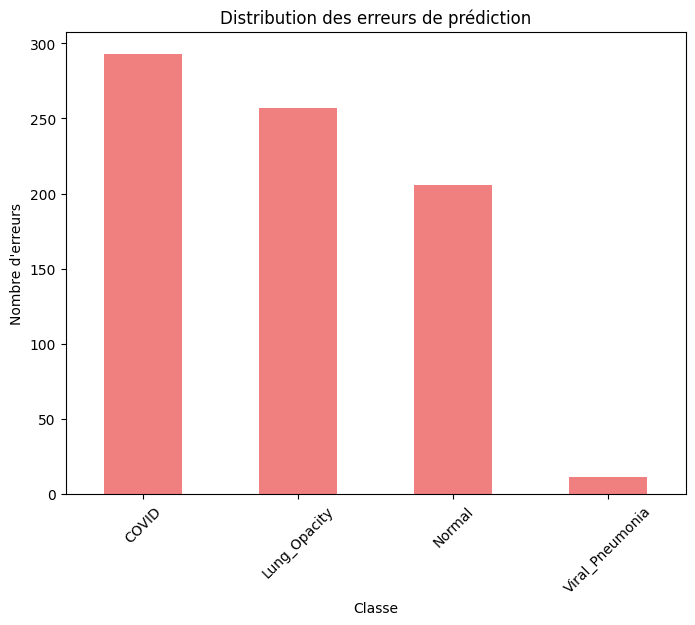

In [ ]:
import pandas as pd

# Créer un DataFrame des prédictions et des vraies valeurs
predictions_df = pd.DataFrame({'true': y_true, 'pred': y_pred})

# Sélectionner les erreurs
errors = predictions_df[predictions_df['true'] != predictions_df['pred']]

# Afficher la distribution des erreurs par classe
errors_count = errors['true'].value_counts()

# Créer la figure
plt.figure(figsize=(8, 6))
errors_count.plot(kind='bar', color='lightcoral')
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Classe")
plt.ylabel("Nombre d'erreurs")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.show()


**Interprétation**

Dàprès cette distribution, nous observons que :

<UL>

**Classe COVID-19** :

C’est celle où le modèle fait le plus d’erreurs (~280).

Cela signifie qu’il confond souvent les images COVID avec d’autres classes (probablement Lung_Opacity ou Normal).

**Classe Lung Opacity** :

Deuxième source d’erreurs (~250).

Ces images sont aussi difficiles à distinguer pour le modèle.

**Classe Normal** :

Moins d’erreurs (~200).

Le modèle reconnaît plutôt bien les cas normaux.

**Classe Viral Pneumonia** :

Très peu d’erreurs (~10).

Le modèle est assez fiable pour cette catégorie.

</UL>

- **Visualisation des erreurs de classification**

**But général :**

Identifier et analyser les images que le modèle a mal classées.

Cela aide à comprendre les types d'erreurs que le modèle fait et à guider d'éventuelles améliorations.


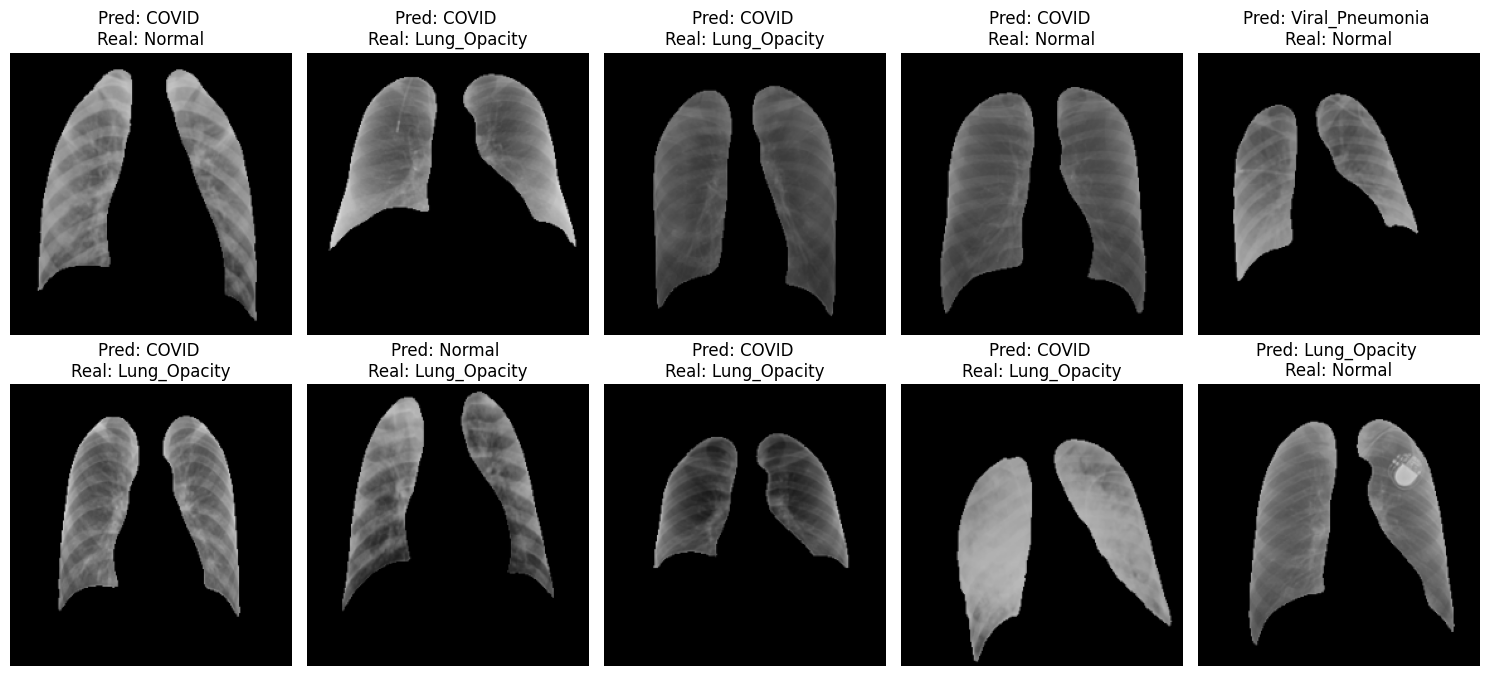

In [ ]:
# === 1. Identifier les erreurs ===
wrong_predictions = np.where(y_pred != y_true)[0]

# === 2. Extraire toutes les images du dataset (batches concaténés) ===
all_images = []
for batch_images, _ in test_ds:
    all_images.append(batch_images.numpy())
all_images = np.concatenate(all_images, axis=0)

# === 3. Afficher les 10 premières images mal classées ===
plt.figure(figsize=(15, 7))
for i, idx in enumerate(wrong_predictions[:10]):
    plt.subplot(2, 5, i + 1)

    # Récupérer l'image correspondante
    image = all_images[idx]

    # Si l'image est normalisée [0,1], remettre en [0,255] pour affichage
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Pred: {class_names[int(y_pred[idx])]} \nReal: {class_names[int(y_true[idx])]}")

plt.tight_layout()
plt.show()
